# Load Libraries

In [92]:
import pickle
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import imblearn.over_sampling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [93]:
relationship_df = pickle.load(open('relationship_clean_df', 'rb'))
person_df = pickle.load(open('person_clean_df', 'rb'))
company_df = pickle.load(open('final_company_features', 'rb'))
degrees_df = pickle.load(open('degrees_grouped_df', 'rb'))
#acquisitions_df = pickle.load(open('acquisitions_df', 'rb'))
#ipo_df = pickle.load(open('ipo_clean_df', 'rb'))
#milestone_df = pickle.load(open('milestones_person_df', 'rb'))

In [94]:
degree_ordinal = {'other': 0,'high_school': 1,
               'associate' :2,'bachelor': 3,
               'master': 4, 'phd_or_above': 5}

# EDA

Text(0.5,1,'Number of Startup in Each Class')

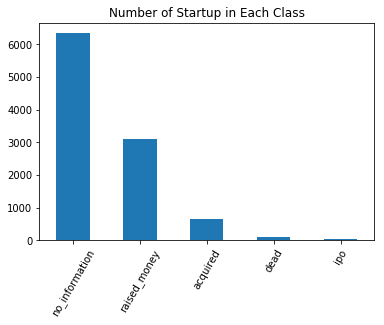

In [95]:
company_df.y.value_counts().plot(kind='bar',rot=60);
plt.title("Number of Startup in Each Class")

Text(0.5,1,'Number of Startup in Each Class')

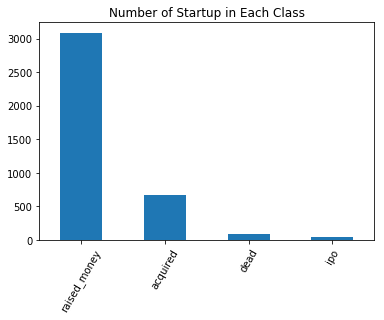

In [96]:
company_df_tofit = company_df[company_df.y != 'no_information']
company_df_tofit.y.value_counts().plot(kind='bar',rot=60);
plt.title("Number of Startup in Each Class")

In [131]:
company_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10232 entries, 0 to 10231
Data columns (total 60 columns):
permalink                           10232 non-null object
name                                10232 non-null object
category_code                       10232 non-null object
description                         10232 non-null object
overview                            10232 non-null object
founded_year                        10232 non-null int32
y                                   10232 non-null object
#female_founders                    185 non-null float64
#male_founders                      2283 non-null float64
#total_founders                     10232 non-null float64
nth_startup                         10232 non-null float64
0.0                                 10232 non-null uint8
1.0                                 10232 non-null uint8
2.0                                 10232 non-null uint8
3.0                                 10232 non-null uint8
4.0                      

In [97]:
company_df_tofit = company_df_tofit.drop('other', axis=1)
company_df_tofit= company_df_tofit.rename(columns={'founders_edu_points': 'founder_edu_exp_points',
                                 'buss_econ': '#founders_with_econ_background',
                                 'science_eng': '#founders_with_STEM_background',
                                 'lib_art' :'#founders_with_liberal_arts_background',
                                 'tech': '#founders_with_tech_background'})

In [98]:
categories = pd.get_dummies(company_df_tofit.category_code, prefix='category')
categories = categories.drop("category_other", axis=1)
category_names = categories.columns.tolist()
company_df_tofit = pd.concat([company_df_tofit,categories], axis=1)

In [121]:
company_df_tofit.y.value_counts()

raised_money    3086
acquired         661
dead              90
ipo               49
Name: y, dtype: int64

In [122]:
balanced = pd.concat([company_df_tofit[company_df_tofit.y!='raised_money'], 
                      company_df_tofit[company_df_tofit.y=='raised_money'].sample(frac=0.25)])

In [123]:
balanced_fillna = balanced.fillna(0)

In [124]:
balanced_fillna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1572 entries, 0 to 3002
Data columns (total 77 columns):
permalink                                 1572 non-null object
name                                      1572 non-null object
category_code                             1572 non-null object
description                               1572 non-null object
overview                                  1572 non-null object
founded_year                              1572 non-null int32
y                                         1572 non-null object
#female_founders                          1572 non-null float64
#male_founders                            1572 non-null float64
#total_founders                           1572 non-null float64
nth_startup                               1572 non-null float64
0.0                                       1572 non-null uint8
1.0                                       1572 non-null uint8
2.0                                       1572 non-null uint8
3.0        

# Modeling

## train-test split

In [127]:
train, test = train_test_split(balanced_fillna, test_size=0.2)

## Cross Validation

* cross validated KNN
* cross validated Logistic Regression
* tune hyperparameters
* cross valiated over different feature sets

In [ ]:
founders = ['#female_founders','#male_founders','#total_founders', 'nth_startup']
founder_edu_level1 = [1.0, 2.0, 3.0, 4.0, 5.0]
founder_edu_level2 = ['founder_edu_exp_points']
founder_backgroud = [ '#founders_with_econ_background', 
                     '#founders_with_STEM_background',
                     '#founders_with_liberal_arts_background', 
                     '#founders_with_tech_background ']

feature_sets = {'founders': founders, 
                'founder_edu_level_category': founder_edu_level1,
                'founder_edu_level_ordinal': founder_edu_level2, 
                'founder_edu_background': founder_backgroud,
                'founder_edu_info': founder_edu_level2+founder_backgroud,
                'category_names': category_names, 
                'all_founder_info': founders+founder_edu_level2+founder_backgroud,
                'category+basic_founder_info': category_names+founders,
                'category+founder_edu':category_names+founder_edu_level2+founder_backgroud,
                'all_features': category_names+founders+founder_edu_level2+founder_backgroud
               }

feature_perf_dict = {}

for key, value in feature_sets.items():
    X_subfeatures = train[value]
    ROS = imblearn.over_sampling.RandomOverSampler()
    X_tr_rs, y_tr_rs = ROS.fit_sample(X_subfeatures, train.y)
    
    k_range = list(range(10, 200, 10))
    k_scores = []
    c_range = 10 ** (np.arange(4.0, -6.0, -1.0))
    c_scores = []

    # search for an optimal value of K for KNN
    for c in c_range:
        log_reg = LogisticRegression(penalty='l1', C=c)
        scores = cross_val_score(log_reg, X_tr_rs, y_tr_rs, cv=10, scoring='accuracy')
        c_scores.append(scores.mean())
    c_scores = np.array(c_scores)
    feature_perf_dict[key] = {}
    feature_perf_dict[key]['log_reg'] = (c_range[c_scores.argmax()], c_scores.max())


    # search for an optimal value of K for KNN
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_tr_rs, y_tr_rs, cv=10, scoring='accuracy')
        k_scores.append(scores.mean())
    k_scores = np.array(k_scores)
    feature_perf_dict[key]['knn'] = (k_range[k_scores.argmax()], k_scores.max())

In [77]:
knn_vs_features = [feature_perf_dict[x]['knn'][1] for x in feature_perf_dict.keys()]
logreg_vs_features = [feature_perf_dict[x]['log_reg'][1] for x in feature_perf_dict.keys()]

In [78]:
feature_perf_dict

{'all_features': {'knn': (10, 0.57694193061840127),
  'log_reg': (10000.0, 0.49709653092006034)},
 'all_founder_info': {'knn': (10, 0.50921945701357463),
  'log_reg': (0.10000000000000001, 0.42083333333333339)},
 'category+basic_founder_info': {'knn': (20, 0.44196832579185513),
  'log_reg': (10.0, 0.41638386123680249)},
 'category+founder_edu': {'knn': (10, 0.534907616892911),
  'log_reg': (10000.0, 0.49226055806938157)},
 'category_names': {'knn': (130, 0.33618966817496226),
  'log_reg': (1.0, 0.37531108597285068)},
 'founder_edu_background': {'knn': (20, 0.36804298642533934),
  'log_reg': (0.10000000000000001, 0.35876696832579186)},
 'founder_edu_info': {'knn': (10, 0.44484351432880842),
  'log_reg': (10000.0, 0.3621417797888386)},
 'founder_edu_level_category': {'knn': (180, 0.3782522624434389),
  'log_reg': (10000.0, 0.35935143288084465)},
 'founder_edu_level_ordinal': {'knn': (180, 0.36650641025641029),
  'log_reg': (0.01, 0.33568061840120667)},
 'founders': {'knn': (60, 0.3260652

Text(0.5,0,'Model Accuracy')

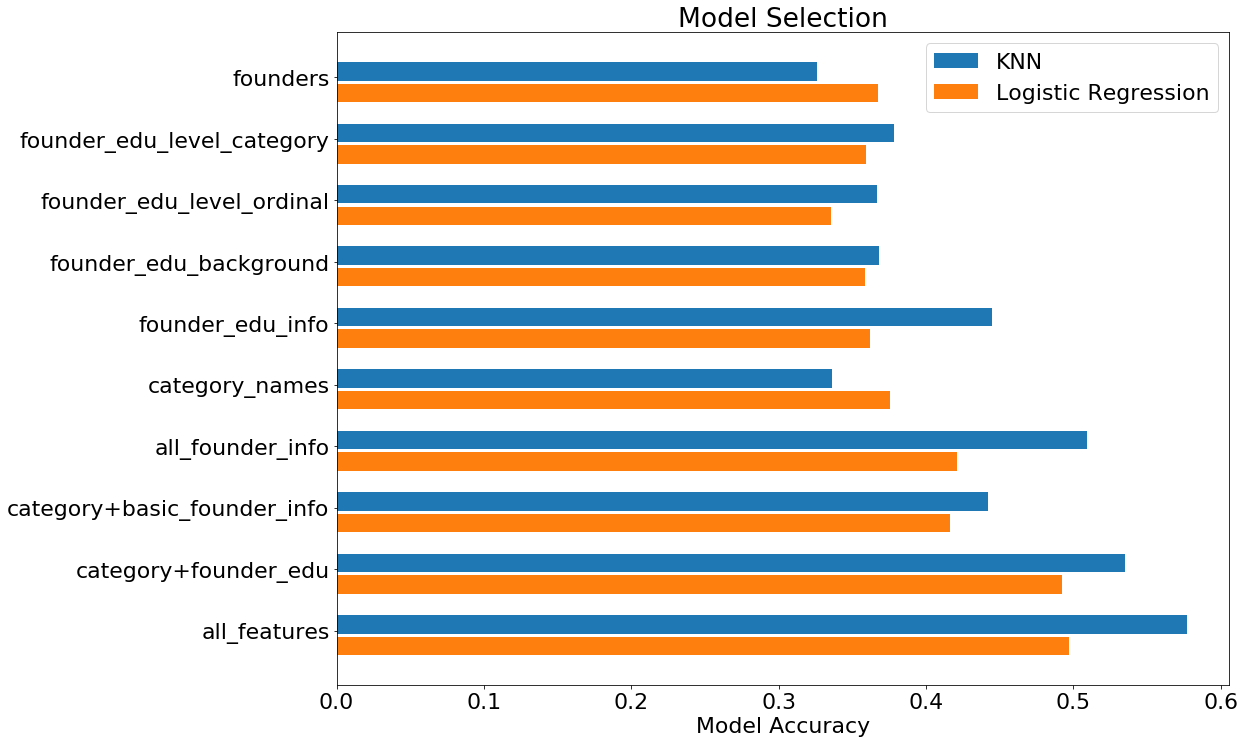

In [79]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(16, 12))
x_axis = np.arange(0,2*len(feature_perf_dict.keys()),2)
plt.barh(x_axis, knn_vs_features, 0.6, align='edge',label='KNN')
plt.barh(x_axis+1, logreg_vs_features, 0.6,  label='Logistic Regression')
plt.yticks(x_axis+0.5, feature_perf_dict.keys())
plt.gca().invert_yaxis()
plt.legend()
plt.title("Model Selection")
plt.xlabel("Model Accuracy")

** Final Model Selection: Logicstic Regression Using All Features**

Following is the classification report on test set

In [81]:
from sklearn.metrics import classification_report

X_subfeatures = train[feature_sets['all_features']]
ROS = imblearn.over_sampling.RandomOverSampler()
X_tr_rs, y_tr_rs = ROS.fit_sample(X_subfeatures, train.y)
KNN = KNeighborsClassifier(n_neighbors=feature_perf_dict['all_features']['knn'][0])
KNN.fit(X_tr_rs, y_tr_rs)
print(classification_report(test.y, KNN.predict(test[feature_sets['all_features']])))

              precision    recall  f1-score   support

    acquired       0.51      0.30      0.38       144
        dead       0.07      0.27      0.11        15
         ipo       0.14      0.50      0.22        10
raised_money       0.43      0.38      0.40       115

 avg / total       0.44      0.34      0.37       284



**Plot out each feature coefficient for each class**

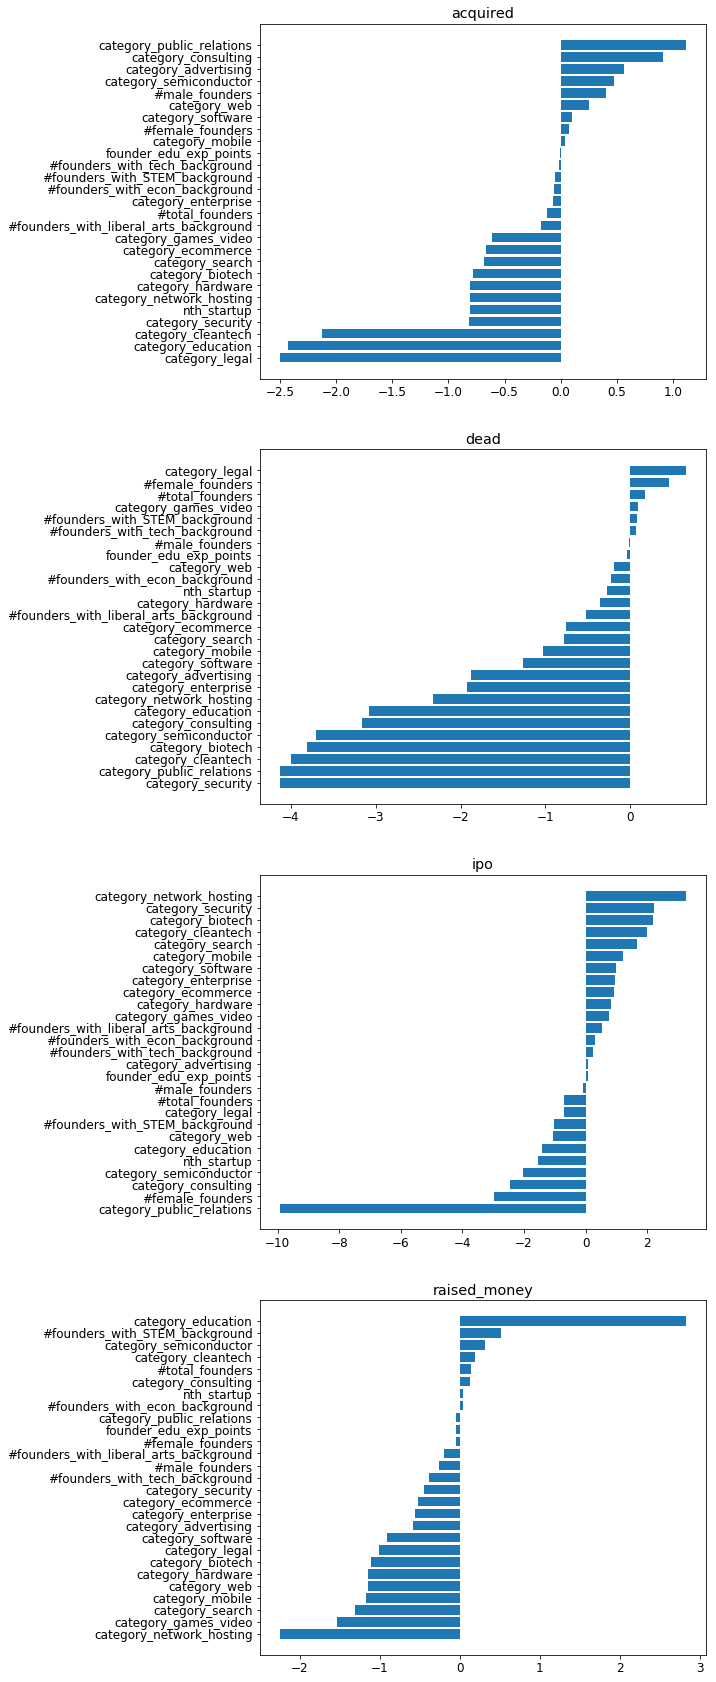

In [49]:
classes = LogReg.classes_
matplotlib.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(4,1, figsize=(8,30))

for i, class_ in enumerate(classes):
    feature_importance = list(zip(feature_sets['all_features'], LogReg.coef_[i]))
    feature_importance.sort(key=lambda x: x[1])
    feature_plot = [x[0] for x in feature_importance]
    importance_plot = [x[1] for x in feature_importance]
    
    axes[i].barh(np.arange(27), importance_plot)
    axes[i].set_yticks(np.arange(len(feature_plot)))
    axes[i].set_yticklabels(feature_plot)
    axes[i].set_title(class_)


## Use Decision Tree to Confirm Feature Importance

In [55]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_tr_rs)
y_tr_rs_encoder = le.transform(y_tr_rs) 


In [56]:
from sklearn import tree

# Set some parameters
#dtrmodel = tree.DecisionTreeRegressor(min_samples_split=10, max_depth=4)
dtrmodel = tree.DecisionTreeClassifier(min_samples_split=10, max_depth=6, min_samples_leaf=8)

# Fit the model to some training data
dtrmodel.fit(X_tr_rs, y_tr_rs_encoder)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [57]:
tree.export_graphviz(dtrmodel, out_file='tree.dot',feature_names = feature_sets['all_features'])


In [60]:
fi = list(zip(feature_sets['all_features'],
              dtrmodel.feature_importances_))
fi.sort(key=lambda x: x[1])
fi

[('category_advertising', 0.0),
 ('category_biotech', 0.0),
 ('category_cleantech', 0.0),
 ('category_consulting', 0.0),
 ('category_ecommerce', 0.0),
 ('category_education', 0.0),
 ('category_enterprise', 0.0),
 ('category_hardware', 0.0),
 ('category_legal', 0.0),
 ('category_mobile', 0.0),
 ('category_public_relations', 0.0),
 ('category_search', 0.0),
 ('category_security', 0.0),
 ('category_semiconductor', 0.0),
 ('category_software', 0.0),
 ('#female_founders', 0.0),
 ('#founders_with_STEM_background', 0.019992608312596177),
 ('category_games_video', 0.038581344060759838),
 ('#total_founders', 0.044655070676564441),
 ('#founders_with_tech_background', 0.048145936026647379),
 ('#male_founders', 0.048787436658106691),
 ('nth_startup', 0.04911729506695605),
 ('#founders_with_econ_background', 0.05239694179164596),
 ('category_network_hosting', 0.079862803962093498),
 ('category_web', 0.085030092429445689),
 ('#founders_with_liberal_arts_background', 0.087129585105951646),
 ('founder

In [59]:
y_test_rs_encoder = le.transform(test.y) 
print(classification_report(y_test_rs_encoder, dtrmodel.predict(test[feature_sets['all_features']])))

             precision    recall  f1-score   support

          0       0.48      0.10      0.17       118
          1       0.08      0.44      0.14        16
          2       0.10      0.23      0.14        13
          3       0.50      0.53      0.51       137

avg / total       0.45      0.33      0.33       284

